In [1]:
#!pip install pandasdatareader

In [2]:
#!pip install yfinance

In [3]:
#!pip install numpy==1.19.5

In [4]:
#!conda install numpy=1.19.5 -c conda-forge

# 모듈로드

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
import datetime
import yfinance as yf

# 데이터 로드

In [6]:
data = yf.download('TQQQ') # , start = '2020-01-01', end = '2021-01-01'
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-02-11,0.406875,0.434896,0.405573,0.432552,0.431471,3456000
2010-02-12,0.420781,0.438073,0.418333,0.434323,0.433238,8601600
2010-02-16,0.444531,0.452188,0.437552,0.451146,0.450019,9619200
2010-02-17,0.457188,0.458906,0.450313,0.458802,0.457656,19180800
2010-02-18,0.458333,0.470260,0.455573,0.467500,0.466332,38860800
...,...,...,...,...,...,...
2022-06-14,23.639999,23.870001,22.520000,23.230000,23.230000,196600500
2022-06-15,24.059999,25.920000,23.340000,24.900000,24.900000,274911500
2022-06-16,22.990000,23.120001,21.320000,21.860001,21.860001,212142200


# Close값 받아주기

In [7]:
#high_prices = data['High'].values
#low_prices = data['Low'].values
mid_prices = data['Close'].values

# Create Windows(51개씩 데이터 끊어서 50개를 보고 1개예측)

In [8]:
seq_len = 50 # 윈도우 사이즈 최근 50일보고 한개를 예측한다. 51개씩저장해야한다.
sequence_length = seq_len + 1 # 51개 저장.

result = []
for index in range(len(mid_prices)-sequence_length):
    result.append(mid_prices[index:index + sequence_length])

# Normalize Data

In [9]:
normalized_data = []
for window in result:
    normalized_window = [((float(p)/float(window[0]))-1)for p in window]
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0]*0.9)) # 90퍼센트 트레이닝셋.
train = result[:row,:]
np.random.shuffle(train) # 트레이닝셋 순서 랜덤으로 셔플

x_train = train[:, :-1]
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
y_test = result[row:, -1]

x_train.shape, x_test.shape 

((2754, 50, 1), (306, 50, 1))

# Build a Model

In [10]:
m = Sequential()
m.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
m.add(LSTM(64,return_sequences=False))
m.add(Dense(1,activation='linear'))
m.compile(loss='mse',optimizer='rmsprop')
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [11]:
m.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=20)

Epoch 1/20
276/276 [==============================] - 8s 22ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 2/20
276/276 [==============================] - 6s 20ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/20
276/276 [==============================] - 6s 21ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/20
276/276 [==============================] - 6s 20ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 5/20
276/276 [==============================] - 6s 20ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/20
276/276 [==============================] - 6s 21ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 7/20
276/276 [==============================] - 6s 22ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 8/20
276/276 [==============================] - 6s 21ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 9/20
276/276 [==============================] - 6s 21ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 10/20
276/276 [==============================] - 6s 20ms/step - loss: 0.0015 - val_lo

# Prediction

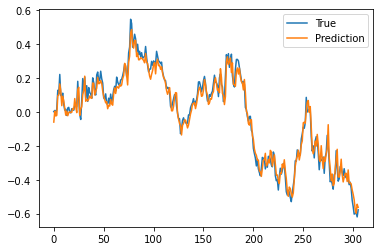

In [12]:
pred = m.predict(x_test)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()
# 파랑색 - 실제데이터
# 주황색 - 예측데이터